# Example 1: The Turtlebot 

In this notebook, we walk through how one might implement dynamics of a system in a turtlebot in such a way taht the we can test it out and then port it over to ROS so that we can test it out in real life and see how it works

## Dynamics of the Turtlebot

The turtlebot uses a kinematic model, so its dynamics are given by -- and also it is a continuous time-invariant model
(lat)
While the turtlebot has its own odometry readings, we use a mocab system for this example for position readings. The mocab is used to compute range from the origin.
(im)
The inputs of the turtlebot are given by the ROS node {name_of_turtlebot}/cmd_vel, with the following structure:
(text)


in other words, the v and w are linear and angular velocity. 

First, we model the system in software

We assume no process noise and small measurement noise distributed equally amongst the measurement states. 


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykal_core.control_system.system import System
from numpy.typing import NDArray
from typing import Callable,Optional

def turtlebot_dynamics(xk: NDArray, uk: NDArray) -> NDArray:
    theta = xk[2, 0]  
    v = uk[0, 0]      
    w = uk[1, 0]
    dx = np.array([
        [v * np.cos(theta)],
        [v * np.sin(theta)],
        [w],
    ])
    return dx

def mocab(xk:NDArray) -> NDArray:
    x = xk[0]
    y = xk[1]
    return np.array([np.sqrt(x**2 + y**2)])

def full_state_measurements(xk:NDArray)-> NDArray:
    return xk

state_names = ["x", "y","theta"]
measurement_names_range = ["range"]

turtlebot = System(
    f= turtlebot_dynamics,
    h = mocab,
    Q = System.make_Q(state_names=state_names,multiply_Q_by_scalar=0),
    R = System.make_R(measurement_names=measurement_names_range,multiply_R_by_scalar=0.01),
    state_names=state_names,
    measurement_names=measurement_names_range,
    system_type="cti")


As we are working with a kinematic model, we may construct the inputs from primitives. The magnitudes can be functions of time. This allows constructions of arbitrarily complex inputs from conceptual primitives 

In [3]:
def forward_v(magnitude_v: float = 0.25): # m/s (max for turtlebot4)
    return np.array([[magnitude_v], [0]])


def backward_v(magnitude_v: float = 0.25):
    return np.array([[-magnitude_v], [0]])


def ccw_w(magnitude_w: float = 0.5): # rad/s (max for turtlebot4)
    return np.array([[0], [magnitude_w]])

def cw_w(magnitude_w: float = 0.5):
    return np.array([[0],[-magnitude_w]])

def no_vw():
    return np.array([[0],[0]])

In [4]:
def move_forward(tk: float, t_start: float, t_end: float, magnitude_v: float = 1) -> Optional[NDArray]:
    if t_start <= tk < t_end:
        return forward_v(magnitude_v)

def circle_cw(tk: float, t_start: float, t_end: float, magnitude_v: float = 1, magnitude_w: float = 1) -> Optional[NDArray]:
    if t_start <= tk < t_end:
        return forward_v(magnitude_v) + cw_w(magnitude_w)

def circle_ccw(tk: float, t_start: float, t_end: float, magnitude_v: float = 1, magnitude_w: float = 1) -> Optional[NDArray]:
    if t_start <= tk < t_end:
        return forward_v(magnitude_v) + ccw_w(magnitude_w)

In [5]:
def straight_loop_straight(tk: float) -> Optional[NDArray]:
    return next((
        movement for movement in [
            move_forward(tk,0, 2,magnitude_v=0.25),
            circle_ccw(tk,2, 10,magnitude_v=0.25,magnitude_w=0.5), 
            move_forward(tk,10, 15,magnitude_v=0.25), 
            circle_cw(tk,15, 25,magnitude_v=0.25,magnitude_w=0.5),
            move_forward(tk,25, 35,magnitude_v=0.25),
            no_vw()
        ] if movement is not None
    ), None)

<Axes: title={'center': 'Input Signals'}, xlabel='Time', ylabel='Value'>

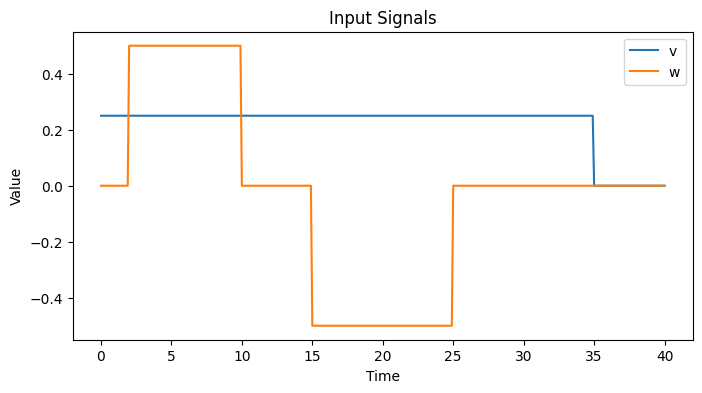

In [6]:
from pykal_core.utils import compute


Uf = compute.Simulation.of_signals(turtlebot,
                                   straight_loop_straight,
                                   t_span=(0,40),                  
                                    dt=0.1,
                                    output_df=True)
Uf.columns = ["v", "w"]
Uf.plot(title="Input Signals", xlabel="Time", ylabel="Value", figsize=(8, 4))

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

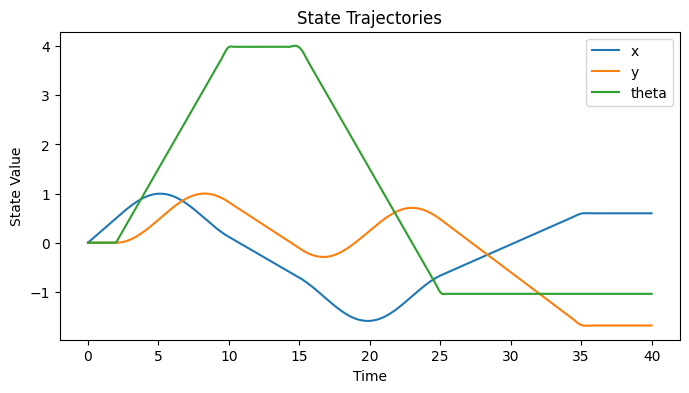

In [7]:
from pykal_core.utils import compute

x0 = np.array([[0,0,0]]).T
X_true_df = compute.Simulation.of_state_trajectories(sys=turtlebot,
                                                      x0=x0,
                                                      t_span=(0,40),
                                                      dt=0.1,
                                                      override_system_Q=False,
                                                      signal=straight_loop_straight,
                                                      output_df=True)
X_true_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

<Axes: title={'center': '2D Trajectory'}, xlabel='x'>

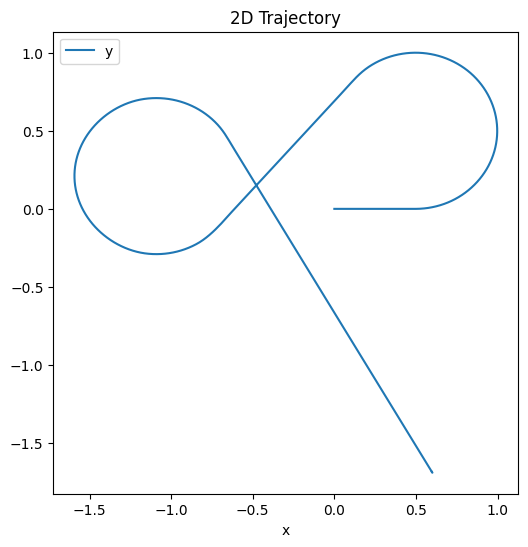

In [ ]:
X_true_df.plot(x="x", y="y", kind="line", figsize=(6, 6), title="2D Trajectory")

In [11]:
X_true_df

,x,y,theta
time,,,
0.0,0.000000,0.000000,0.000000
0.1,0.025000,0.000000,0.000000
0.2,0.050000,0.000000,0.000000
0.3,0.075000,0.000000,0.000000
0.4,0.100000,0.000000,0.000000
...,...,...,...
39.6,0.598186,-1.685295,-1.040632
39.7,0.598186,-1.685295,-1.040632
39.8,0.598186,-1.685295,-1.040632


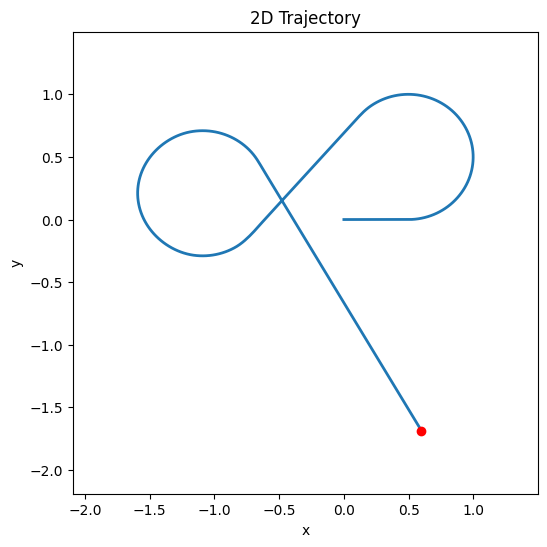

In [17]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# Ensure index is not used by accident
x_vals = X_true_df["x"].values
y_vals = X_true_df["y"].values

plt.close("all")  # Clear prior figures
fig, ax = plt.subplots(figsize=(6, 6))
line, = ax.plot([], [], lw=2)
point, = ax.plot([], [], 'ro')  # moving point

ax.set_xlim(x_vals.min() - 0.5, x_vals.max() + 0.5)
ax.set_ylim(y_vals.min() - 0.5, y_vals.max() + 0.5)
ax.set_title("2D Trajectory")
ax.set_xlabel("x")
ax.set_ylabel("y")

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def update(frame):
    x = x_vals[:frame+1]
    y = y_vals[:frame+1]

    line.set_data(x, y)
    point.set_data([x[-1]], [y[-1]])  # These MUST be 1-element sequences

    return line, point
ani = FuncAnimation(
    fig, 
    update, 
    frames=len(x_vals), 
    init_func=init, 
    blit=True, 
    interval=100  # 100 ms per frame = 0.1 seconds
)

# Display in notebook with correct playback speed
HTML(ani.to_jshtml())

# Save GIF with 10 fps = 0.1 sec per frame
ani.save("trajectory.gif", writer=PillowWriter(fps=10))


In [18]:
from pykal.control_system.signals import Signals
turtlebot_signal = Signals(sys=turtlebot,user_defined_signal=straight_loop_straight)

In [20]:
import dill
# Save to file
with open("turtlebot_signal.dill", "wb") as f:
    dill.dump(turtlebot_signal, f)

In [21]:
# Load from file
with open("turtlebot_signal.dill", "rb") as f:
    loaded_signal = dill.load(f)

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

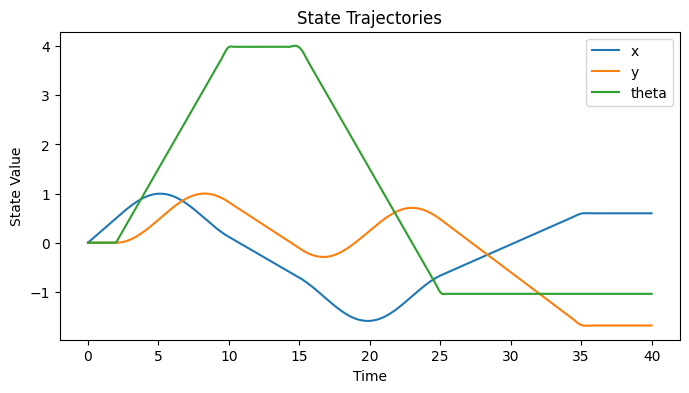

In [23]:
x0 = np.array([[0,0,0]]).T
X_true_df = compute.Simulation.of_state_trajectories(sys=turtlebot,
                                                      x0=x0,
                                                      t_span=(0,40),
                                                      dt=0.1,
                                                      override_system_Q=False,
                                                      signal=loaded_signal.user_signal,
                                                      output_df=True)
X_true_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

<Axes: title={'center': '2D Trajectory'}, xlabel='x'>

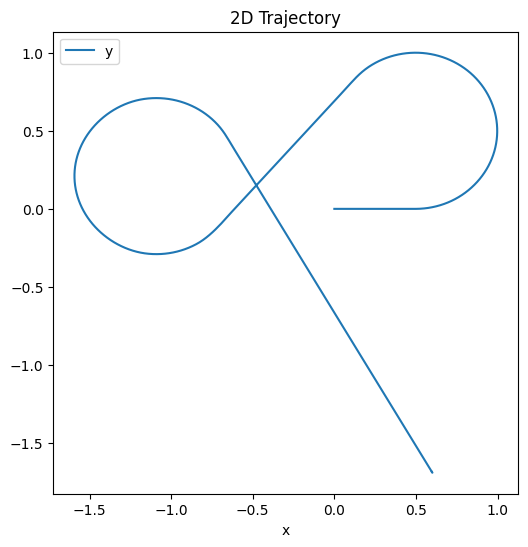

In [24]:
X_true_df.plot(x="x", y="y", kind="line", figsize=(6, 6), title="2D Trajectory")

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.collections import LineCollection
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# # Assume X_true_df has columns "x", "y", and time index or "t" column
# x = X_true_df["x"].to_numpy()
# y = X_true_df["y"].to_numpy()
# t = X_true_df.index.to_numpy() if "t" not in X_true_df.columns else X_true_df["t"].to_numpy()

# # Create line segments
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)

# # Color line by time
# lc = LineCollection(segments, cmap="viridis", linewidth=2)
# lc.set_array(t)

# # Plot
# fig, ax = plt.subplots(figsize=(6, 6))
# line = ax.add_collection(lc)


# # Set equal limits and aspect ratio
# min_val = min(x.min(), y.min())
# max_val = max(x.max(), y.max())
# ax.set_xlim(min_val, max_val)
# ax.set_ylim(min_val, max_val)
# ax.set_aspect("equal", adjustable="box")

# ax.set_title("2D Trajectory Colored by Time")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.grid(True)
# plt.show()


In [10]:
Y_df = sys.simulate_measurements(X_df=X_true_df,input_df=True,output_df =True)
Y_df.plot(title="Measurement Trajectory", xlabel="Time", ylabel="Value", figsize=(8, 4))

NameError: name 'sys' is not defined

In [ ]:
from pykal.utils import compute 

In [ ]:
state_observability_over_time = compute.Observability.of_states_over_time_from_grammian_via_callable(sys=sys,
                                                                                                     x0=x0,
                                                                                                     grammian_to_scores_func=compute.Observability.of_states_from_grammian_nullspace,
                                                                                                     t_vector=T,
                                                                                                    divide_time_into_k_windows=50,
                                                                                                    output_df=True)

<Axes: xlabel='time'>

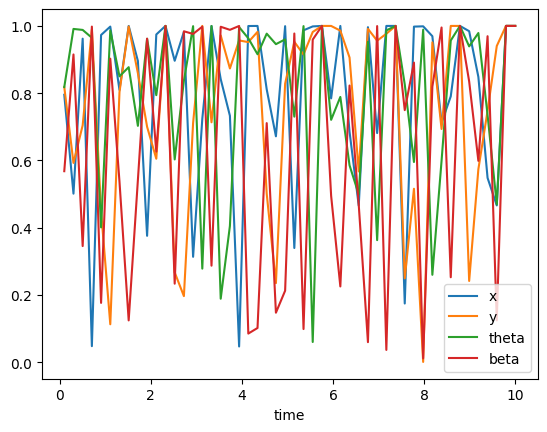

In [ ]:
state_observability_over_time.plot()

<Axes: xlabel='time'>

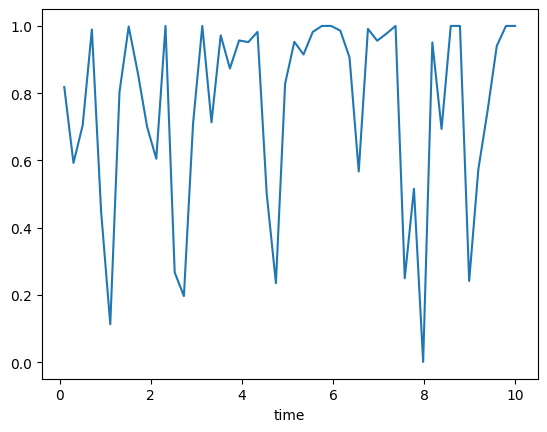

In [ ]:
state_observability_over_time["y"].plot()

<Axes: xlabel='time'>

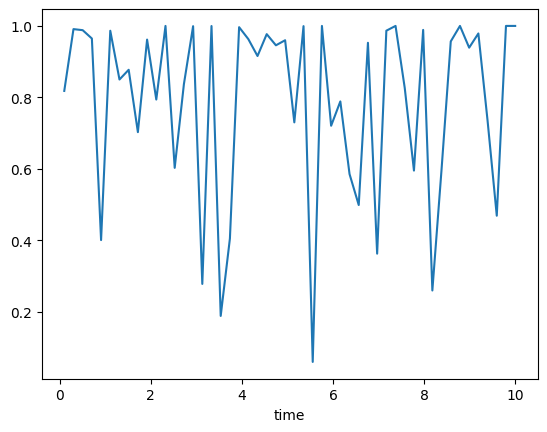

In [ ]:
state_observability_over_time["theta"].plot()

In [ ]:
from pykal.control_system.observer import Observer
obs = Observer(sys)

In [ ]:
x0

array([[0. ],
       [0. ],
       [0. ],
       [0.3]])

In [ ]:
def nullspace_beta(tk: float) -> NDArray:
    """
    Return the observability-based beta vector at time closest to `tk`.
    """
    index_array = state_observability_over_time.index.to_numpy()
    closest_idx = np.abs(index_array - tk).argmin()
    closest_time = index_array[closest_idx]
    row = state_observability_over_time.loc[closest_time]
    return row.to_numpy()

def stochastic_beta(P0:NDArray,Pk:NDArray) -> NDArray:
    return 1 - compute.Observability.of_states_from_P_projection_onto_canonical_basis(sys=obs.sys,P0=P0,Pk=Pk)

P0 = np.eye(4) * 0.01
np.random.seed(58)  # Set seed for reproducibility
x_est = x0 + np.random.multivariate_normal(mean=[0, 0,0,0], cov=P0).reshape(4,1)

beta_nullspace_log = pd.DataFrame(columns=state_names)
beta_stochastic_log = pd.DataFrame(columns=state_names)

X_est_df, P_est_sr = obs.ekf.run(x0=x_est,P0=P0,Y_df=Y_df, input_df=True, output_df=True)
X_est_null_df, P_est_null_sr = obs.ekf.run(x0=x_est,P0=P0,Y_df=Y_df, input_df=True, output_df=True, 
                                           override_update=obs.ekf.override_update_partial(nullspace_beta,beta_nullspace_log))
X_est_stoch_df, P_est_stoch_sr = obs.ekf.run(x0=x_est,P0=P0,Y_df=Y_df, input_df=True, output_df=True,
                                            override_update=obs.ekf.override_update_partial(stochastic_beta,beta_stochastic_log))


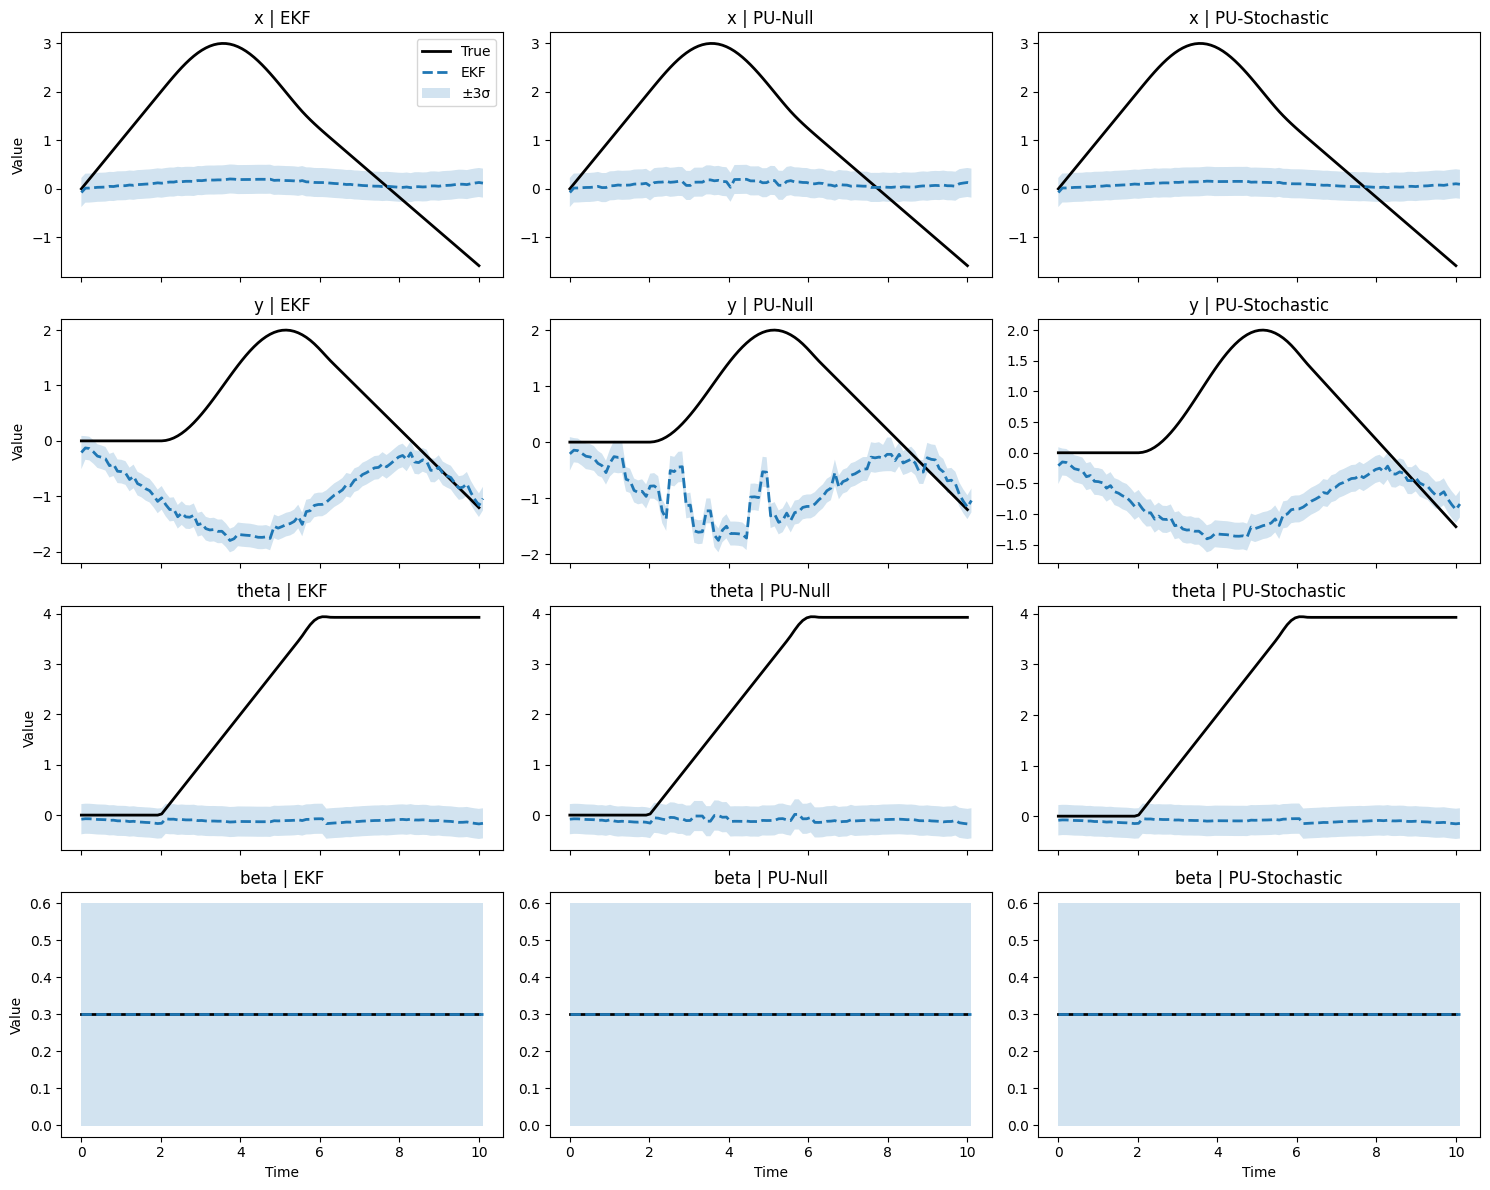

In [ ]:
# Dictionary of (estimate_df, covariance_list)
dfs = {
    "EKF": (X_est_df, P_est_sr),
    "PU-Null": (X_est_null_df, P_est_null_sr),
    "PU-Stochastic": (X_est_stoch_df, P_est_stoch_sr),
}

n_states = len(state_names)
fig, axes = plt.subplots(n_states, len(dfs), figsize=(5 * len(dfs), 3 * n_states), sharex=True)

# Ensure axes is 2D for consistent indexing
if n_states == 1:
    axes = np.expand_dims(axes, 0)

for i, state in enumerate(state_names):
    for j, (label, (X_df, P_list)) in enumerate(dfs.items()):
        ax = axes[i, j]

        # Plot true state
        if state in X_true_df.columns:
            X_true_df[state].plot(ax=ax, color="black", linestyle="-", linewidth=2, label="True")

        # Plot estimated mean
        mean = X_df["est_" + state]
        mean.plot(ax=ax, linestyle="--", linewidth=2, label=label)

        # ±3σ bounds
        state_index = X_df.columns.get_loc("est_" + state)
        std = np.array([np.sqrt(P[state_index, state_index]) for P in P_list])
        ax.fill_between(
            X_df.index,
            mean - 3 * std,
            mean + 3 * std,
            alpha=0.2,
            label="±3σ"
        )

        # Plot measurements if this state is observed
        if state in Y_df.columns:
            Y_df[state].plot(ax=ax, style="x", markersize=6, label="Measurement")

        ax.set_title(f"{state} | {label}")
        if j == 0:
            ax.set_ylabel("Value")
        if i == n_states - 1:
            ax.set_xlabel("Time")
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
plt.show()